# Investigating the use of the log-likelihood approximation

We'll start by fitting a GP and providing the prediction over the globe as in the demonstration notebook.


In [1]:
import GPy
import sys
import os
sys.path.append(os.getenv("HOME") + "/Documents/Code/Emulation/GPyDifferentMetrics/")
from HaversineDist import Exponentialhaversine
import numpy as np
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import glob as glob
from cmocean import cm as cm
from Utilities import *



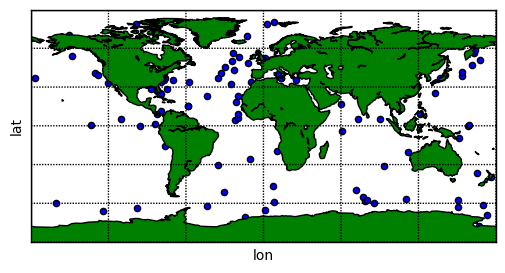

In [2]:

GCM_dir = os.getenv("HOME")+'/Documents/Code/ModelDataComparison/DMC/Scripts/Model_data/CO2_anom/'
gcm_SSTs = glob.glob(GCM_dir+'t*.txt')

gcm_mask = np.genfromtxt(GCM_dir+'mask.txt', dtype='int')

obs_dir = os.getenv("HOME")+'/Documents/Code/ModelDataComparison/DMC/Scripts/Observation_data/P3+_SST_anom/'
file = 'lambda_10.txt'
observations = np.genfromtxt(obs_dir+file, skip_header=1)

X_obs = observations[:,0:2]
y_obs = observations[:,2].reshape(-1,1)
var_ratios = observations[:,3][:,None]**2
map = plot_map(X_obs=X_obs)



In [3]:
from scaledheteroscedasticgaussian import ScaledHeteroscedasticGaussian
from gp_heteroscedastic_ratios import ScaledHeteroscedasticRegression


k3 = Exponentialhaversine(2, lengthscale=2000)
m3 = ScaledHeteroscedasticRegression(X=X_obs, Y=y_obs, kernel=k3, noise_mult=1., 
                                     known_variances=var_ratios)
m3.optimize_restarts(10)



Warning - ARD must be False at the moment
Optimization restart 1/10, f = 202.7394228954263


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:109: RuntimeWarning:overflow encountered in expm1
 /Users/pmzrdw/GPy/GPy/kern/src/stationary.py:160: RuntimeWarning:overflow encountered in true_divide
 /Users/pmzrdw/GPy/GPy/kern/src/stationary.py:198: RuntimeWarning:invalid value encountered in multiply
 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:106: RuntimeWarning:invalid value encountered in greater
 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/paramz/transformations.py:111: RuntimeWarning:invalid value encountered in greater


Optimization restart 2/10, f = 240.99576819890382
Optimization restart 3/10, f = 256.5356758553253
Optimization restart 4/10, f = 230.29148806722367
Optimization restart 5/10, f = 230.2914880666662
Optimization restart 6/10, f = 230.29148806743672
Optimization restart 7/10, f = 230.2914881111637
Optimization restart 8/10, f = 256.5356751557546
Optimization restart 9/10, f = 230.29148806664543
Optimization restart 10/10, f = 256.53567558923277



Name : gp
Objective : 202.7394228954263
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                          |          value  |  constraints  |  priors
  Exponential.variance         |  9.72822417707  |      +ve      |        
  Exponential.lengthscale      |  4778.83030186  |      +ve      |        
  Scaled_het_Gauss.noise_mult  |  7.99632407141  |      +ve      |        


 /Users/pmzrdw/Documents/Code/ModelDataComparison/PythonCode/Utilities.py:91: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.


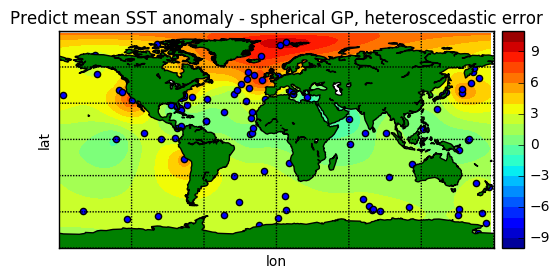

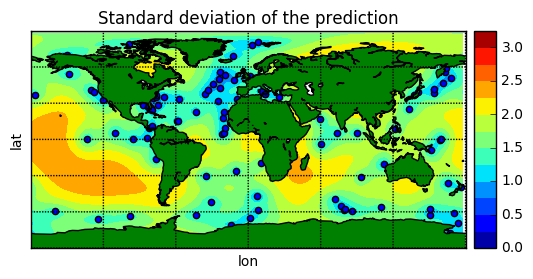

In [4]:
print(m3)

latsplot = np.arange(-90.0,90.0, 2.5)
longsplot = np.arange(-180.0,180.0, 2.5)
longgridplot, latgridplot = np.meshgrid(longsplot, latsplot)
X_plot=np.column_stack((longgridplot.flatten(), latgridplot.flatten())) # specifies the prediction locations


mu3,V3 = m3.predict_noiseless(X_plot)


plt.figure(3)
map=plot_map(longgridplot, latgridplot, mu3, X_obs)
plt.title('Predict mean SST anomaly - spherical GP, heteroscedastic error')

plt.figure(4)
map=plot_map(longgridplot, latgridplot, np.sqrt(V3), X_obs, levels=np.arange(0,np.sqrt(V3).max()+1,0.25))
plt.title('Standard deviation of the prediction')

## Likelihood calculation


Calculating the likelihood for each GCM is expensive. Thus its of interest to thin the GCM grid, and only use the GP to predict a value on a thinned grid, and to use this to estimate the log likelihood. 

Here, we'll try the calculation on the full GCM grid, as well as several coarsenings of it. 
Let's start by loading all the GCM data.

In [5]:
count=0
gcm_runs = np.zeros((8,27186))
gcm_runs_label = gcm_SSTs.copy()

for file_name in gcm_SSTs:
    file_nm = file_name.split(GCM_dir)[-1]
    print(file_nm)
    # Read in GCM output.
    gcm_runs[count,:] = np.genfromtxt(file_name)
    gcm_runs_label[count] = file_nm.split(".txt")[0]
    count +=1

tczyi.txt
tczyj.txt
tczyk.txt
tdgtg.txt
tdgth.txt
tdgti.txt
tdgtj.txt
tdgtk.txt


Now we'll thin the GCM grid and output to various resolutions.

In [6]:
all_gcm_thinned = {}
all_X_pred = {}
for thinby in (np.arange(6)+1):
    tmp1, tmp2 = ThinGrid(gcm_runs[0,:], gcm_mask, thinby=thinby) # just to get size
    gcm_thin = np.zeros((8, tmp2.size))
    for count in range(8):
        X_pred, out = ThinGrid(gcm_runs[count,:], gcm_mask, thinby=thinby)
        gcm_thin[count,:] = out.flatten()
        
    all_gcm_thinned[str(thinby)]= gcm_thin
    all_X_pred[str(thinby)]=X_pred 
    

I've written a custom density function (checked against scipy) that takes the cholesky decomposition of the covariance matrix. This means we only need to compute it once for any given resolution (note if the GP changes we'd have to recompute). Let's predict with the GP on each grid, and then compute the cholesky decomposition of the covariance matrix. This is slow - it takes ~4 minutes to do the Cholesky decomposition for the full grid on my laptop(2.2 Ghz Intel i7, wigh 16GB memory). My desktop machine won't calculate this, I think due to lack of memory rather than computational speed.

In [7]:

Chols = {}
mus = {}
Covs = {}
for thinby in (np.arange(6)+1):
    mus[str(thinby)], Covs[str(thinby)] = m3.predict_noiseless(all_X_pred[str(thinby)], full_cov=True)
    Chols[str(thinby)] = np.linalg.cholesky(Covs[str(thinby)])
    

In [8]:
#import pickle
#np.savetxt('Chol_full.csv', Chols['1'], delimiter=',')
#pickle.dump(Chols['1'] , open( "Chol_full.p", "wb" ) ) - too large to save using pickle
#pickle.dump(m3, open("GP_model.p", "wb"))


Let's now compute the likelihood, and the ordering this suggests for the 8 GCM runs. I've also computed the relative loglikelihood which is the maximum minus the others, so we can see the magnitude of the change.

In [9]:
from Cholesky import *
loglikes={}
orderings={}
relative={}

for thinby in (np.arange(6)+1):
    loglikes[str(thinby)]=dlogmvnorm(all_gcm_thinned[str(thinby)].T, mus[str(thinby)], Chols[str(thinby)])
    orderings[str(thinby)] = np.argsort(-loglikes[str(thinby)]) #minus sign so that max is first
    relative[str(thinby)] = np.round(loglikes[str(thinby)]-np.max(loglikes[str(thinby)]),1)


In [10]:
loglikes

{'1': array([ -6816.15966424,  -7098.9983753 ,  -7807.38607498,  -7406.49459638,
         -6659.75880127, -10610.11020693,  -6989.55283844,  -8104.99549526]),
 '2': array([-4387.73573649, -4412.126893  , -4525.04367229, -4426.15093373,
        -4329.91799525, -5635.8535643 , -4409.37418176, -4602.82662547]),
 '3': array([-2672.83149739, -2659.11419677, -2730.26976868, -2692.40619637,
        -2658.73319596, -3474.6117903 , -2665.55693813, -2792.39173086]),
 '4': array([-1785.38791013, -1788.43603862, -1840.28759343, -1803.00342246,
        -1794.37555694, -2532.78169346, -1779.40402419, -1906.66267842]),
 '5': array([-1350.04901104, -1337.00355768, -1347.33161981, -1328.66019034,
        -1348.74843002, -1784.24393279, -1341.11914014, -1370.06533309]),
 '6': array([ -997.52728007,  -990.85285153, -1006.15494753,  -994.22361996,
        -1004.62735668, -1366.5960644 ,  -984.96097741, -1038.86130124])}

In [11]:
relative

{'1': array([ -156.4,  -439.2, -1147.6,  -746.7,     0. , -3950.4,  -329.8,
        -1445.2]),
 '2': array([  -57.8,   -82.2,  -195.1,   -96.2,     0. , -1305.9,   -79.5,
         -272.9]),
 '3': array([ -1.41000000e+01,  -4.00000000e-01,  -7.15000000e+01,
         -3.37000000e+01,   0.00000000e+00,  -8.15900000e+02,
         -6.80000000e+00,  -1.33700000e+02]),
 '4': array([  -6. ,   -9. ,  -60.9,  -23.6,  -15. , -753.4,    0. , -127.3]),
 '5': array([ -21.4,   -8.3,  -18.7,    0. ,  -20.1, -455.6,  -12.5,  -41.4]),
 '6': array([ -12.6,   -5.9,  -21.2,   -9.3,  -19.7, -381.6,    0. ,  -53.9])}

In [12]:
orderings

{'1': array([4, 0, 6, 1, 3, 2, 7, 5]),
 '2': array([4, 0, 6, 1, 3, 2, 7, 5]),
 '3': array([4, 1, 6, 0, 3, 2, 7, 5]),
 '4': array([6, 0, 1, 4, 3, 2, 7, 5]),
 '5': array([3, 1, 6, 2, 4, 0, 7, 5]),
 '6': array([6, 1, 3, 0, 4, 2, 7, 5])}

The ordering (from best to worst) of the GCM runs, in terms of the CO2 levels used, was (for the full grid) as follows:

In [13]:
dict = {'tdgth': '280 ppm',
        'tczyi': '315 ppm',
    'tdgtj': '350 ppm',
    'tczyj': '375 ppm',
    'tdgtg': '405 ppm',
    'tczyk': '475 ppm',
    'tdgtk': '560 ppm',
    'tdgti': '1000 ppm'}

for ii in range(8):
    print(dict[gcm_runs_label[orderings['1'][ii]]])

280 ppm
315 ppm
350 ppm
375 ppm
405 ppm
475 ppm
560 ppm
1000 ppm


Note that the orderings are the same for the full grid, and the grid thinned to every second value, but that for the grid thinned to every third value, the second and fourth best models swap, and for the coarser orderings seem to be all over the place.


#### Why are the orderings  different?

Let's look at the grid of points to see if there is anything obvious causing this.

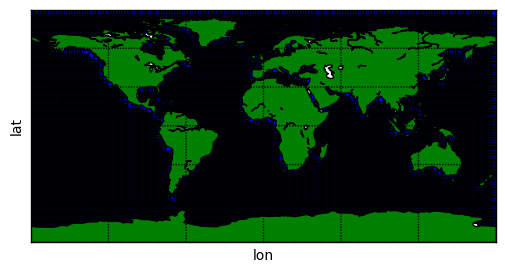

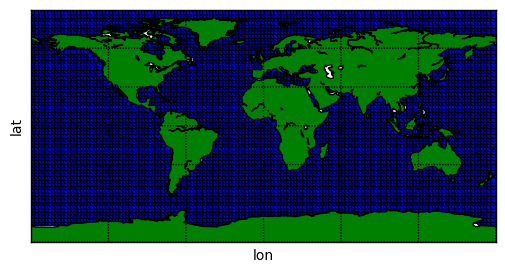

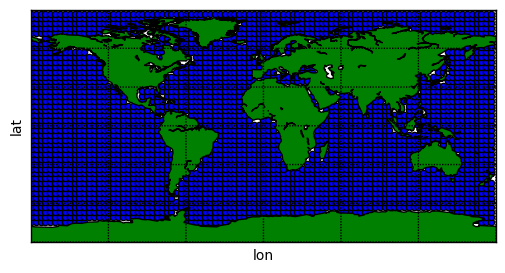

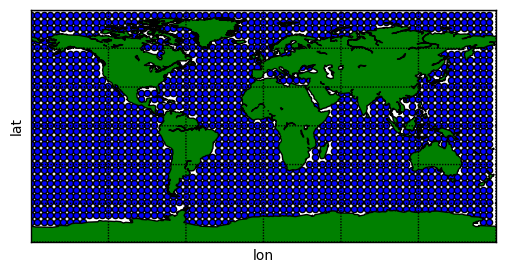

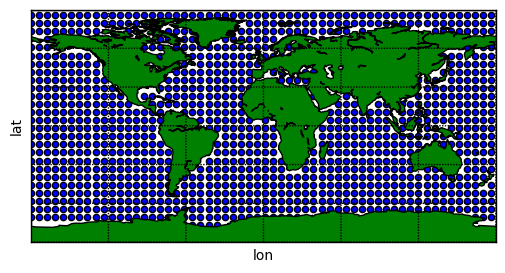

In [14]:
map = plot_map(X_obs=all_X_pred['1'])
plt.figure(2)
map = plot_map(X_obs=all_X_pred['2'])
plt.figure(3)
map = plot_map(X_obs=all_X_pred['3'])
plt.figure(4)
map = plot_map(X_obs=all_X_pred['4'])
plt.figure(5)
map = plot_map(X_obs=all_X_pred['5'])


So the grids don't look that different. Let's check the means don't vary much.



 /Users/pmzrdw/Documents/Code/ModelDataComparison/PythonCode/Utilities.py:43: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.


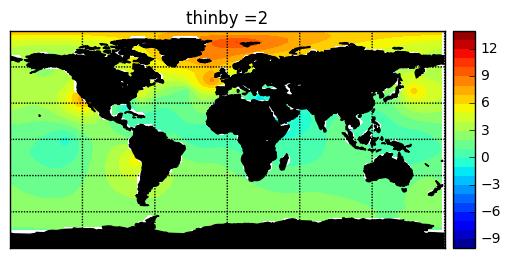

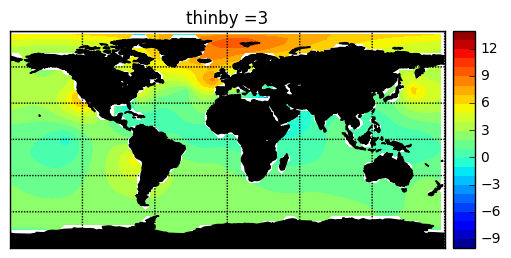

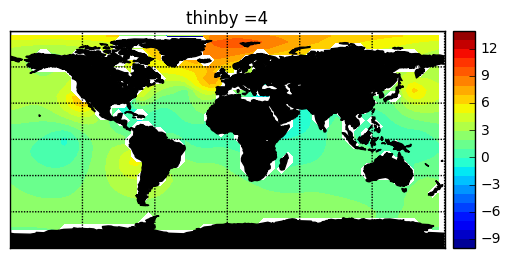

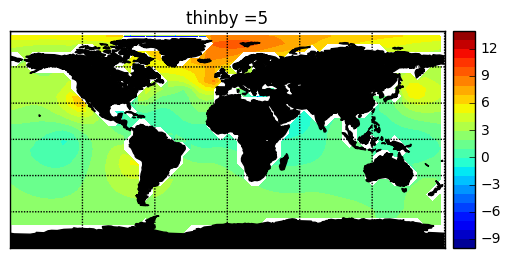

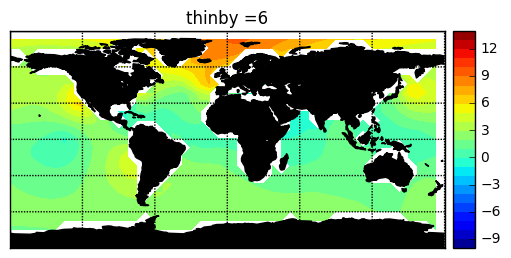

In [15]:
for thinby in (np.arange(5)+2):
    plot_samples(mus[str(thinby)], thinby=thinby, land_mask=gcm_mask, levels=np.arange(-10,15,1))
    plt.title('thinby ='+str(thinby))
    plt.figure()


There are some differences here, noticeably in some of the variation not being resolved. So it's possible this is the root of the problem. Let's check the variances as well.

 /Users/pmzrdw/Documents/Code/ModelDataComparison/PythonCode/Utilities.py:43: FutureWarning:comparison to `None` will result in an elementwise object comparison in the future.


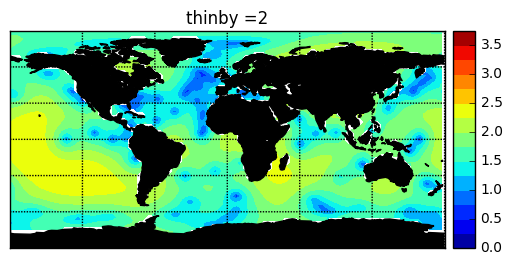

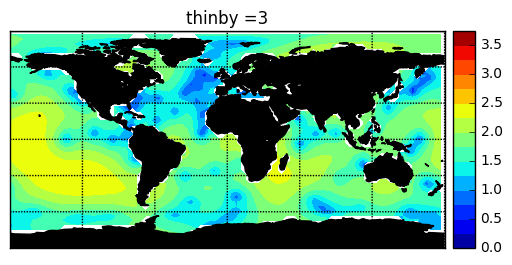

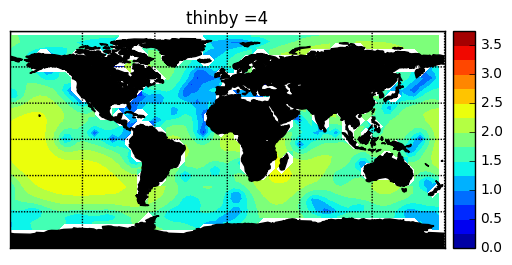

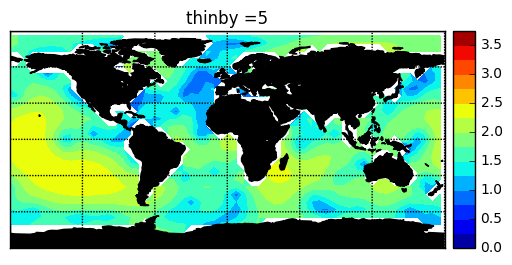

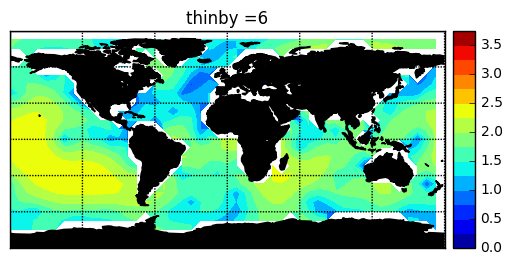

In [16]:
for thinby in (np.arange(5)+2):
    plot_samples(np.sqrt(np.diag(Covs[str(thinby)])), thinby=thinby, land_mask=gcm_mask, levels=np.arange(0,4,0.25))
    plt.title('thinby ='+str(thinby))
    plt.figure()



### Checking the marginals

The marginal distributions should be identical. They look to be from the plots above, but let's rule out any simple errors by checking that for grids 1,2 and 4 that the mean and variances are the same.

In [17]:

for ind4 in np.arange(0,mus['4'].size, 100):
    
    ind1 = np.where((all_X_pred['1'] == all_X_pred['4'][ind4,:]).all(axis=1))
    ind2 = np.where((all_X_pred['2'] == all_X_pred['4'][ind4,:]).all(axis=1))

    print(all_X_pred['1'][ind1,:])
    print(all_X_pred['2'][ind2,:])
    print(all_X_pred['4'][ind4,:])

    print('means')
    print(mus['1'][ind1])
    print(mus['2'][ind2])
    print(mus['4'][ind4])

    print('Covs')
    print(Covs['1'][ind1, ind1])
    print(Covs['2'][ind2, ind2])
    print(Covs['4'][ind4, ind4])



[[[-180.     -74.375]]]
[[[-180.     -74.375]]]
[-180.     -74.375]
means
[[ 1.77793986]]
[[ 1.77793986]]
[ 1.77793986]
Covs
[[ 1.51263329]]
[[ 1.51263329]]
1.51263328917
[[[ 10.    -64.375]]]
[[[ 10.    -64.375]]]
[ 10.    -64.375]
means
[[ 2.74135196]]
[[ 2.74135196]]
[ 2.74135196]
Covs
[[ 1.69902604]]
[[ 1.69902604]]
1.69902603557
[[[ 150.     -59.375]]]
[[[ 150.     -59.375]]]
[ 150.     -59.375]
means
[[ 2.03127574]]
[[ 2.03127574]]
[ 2.03127574]
Covs
[[ 1.18038431]]
[[ 1.18038431]]
1.18038431364
[[[-65.    -49.375]]]
[[[-65.    -49.375]]]
[-65.    -49.375]
means
[[ 2.97958642]]
[[ 2.97958642]]
[ 2.97958642]
Covs
[[ 4.33459451]]
[[ 4.33459451]]
4.3345945096
[[[ 80.    -44.375]]]
[[[ 80.    -44.375]]]
[ 80.    -44.375]
means
[[ 1.96081341]]
[[ 1.96081341]]
[ 1.96081341]
Covs
[[ 2.72887097]]
[[ 2.72887097]]
2.7288709692
[[[-120.     -34.375]]]
[[[-120.     -34.375]]]
[-120.     -34.375]
means
[[ 1.93994511]]
[[ 1.93994511]]
[ 1.93994511]
Covs
[[ 5.85919957]]
[[ 5.85919957]]
5.859199

So the marginals are exactly the same. So the differences we are seeing when we thin the grids is due to small range differences. This is surprising, but correct. I've check the phenomenon for a 1d example as follows:

- generate a fine grid in [0,1]
- pick a kernel and form the covariance matrix for the y-values
- generate 20 samples from the zero mean GP on this grid and evaluate the log-likelihood
- thin these samples and re-evaluate on a finer grid.
- check if the order has changed using Spearman's rank coefficient.

In [18]:
from scipy.stats import multivariate_normal

x = np.linspace(0,1,100)[:,None]
k = GPy.kern.Exponential(1, lengthscale=10)
K = k.K(x)
f_samples = np.random.multivariate_normal(np.zeros(x.size), K, 20)
like=multivariate_normal.logpdf(f_samples, np.zeros(x.size), K)
rank_full=np.argsort(like)

thin = np.arange(0,x.size,2)
xthin = x[thin]
k2 = k.copy()
Kthin = k2.K(xthin)
f_thin = f_samples[:,thin]

like_thin=multivariate_normal.logpdf(f_thin, np.zeros(xthin.size), Kthin)
rank_thin=np.argsort(like_thin)
print(like)
print(rank_full)
print(rank_thin)
#n = rank_thin.size
#print(1-6 *np.sum(np.square(rank_full-rank_thin))/(n*(n**2-1)))

from scipy.stats import spearmanr
print(spearmanr(rank_full, rank_thin))


[ 169.46731424  173.67079294  156.03775003  175.26496959  163.01256772
  165.33287149  162.53043568  175.03407114  166.44166494  167.28729668
  169.41854808  162.02586075  165.4818514   161.93921269  167.53772961
  160.78854911  167.46024676  174.54239602  156.2278007   163.87499836]
[ 2 18 15 13 11  6  4 19  5 12  8  9 16 14 10  0  1 17  7  3]
[11 18  2  4 15 19  3 10 14  6  9  5 16 12  0  1  7 13 17  8]
SpearmanrResult(correlation=0.23759398496240602, pvalue=0.3131305637442674)


What is happening here? There is almost zero correlation between the ordering of the samples when using the full grid and the thinned grid. 

The best explanation I can think of is that the likelihoods are all very close. And so subsampling doesn't need to change them by much to cause a change in the ordering.

I'm satisfied this isn't a bug, and is a consequence of the GP covariance structure we've used. It should perhaps make us pause and think about the wisdom of this. Do we really believe that by thinning the grid to every fourth grid lat and long, we should change the ordering of the GCM runs? The fact that the ordering changes means that correlations over small distances are determining to some extent which runs we favour. We should think about how to know when two GCM runs are genuinely different in quality, and when its short range correlations causing the problem.

#### Acceptance

Our results on the full grid differ from Fran's obtained using the GMRF approach. However, if we use a coarser grid, then we get results that resemble Fran's:

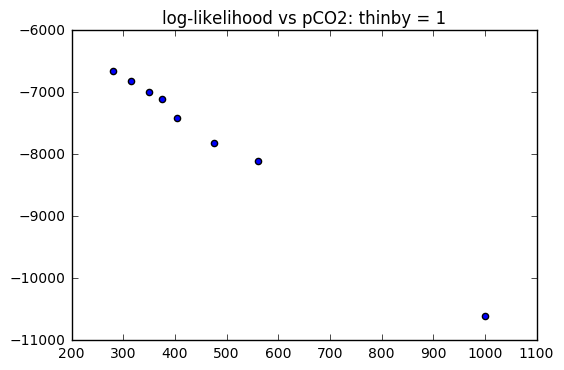

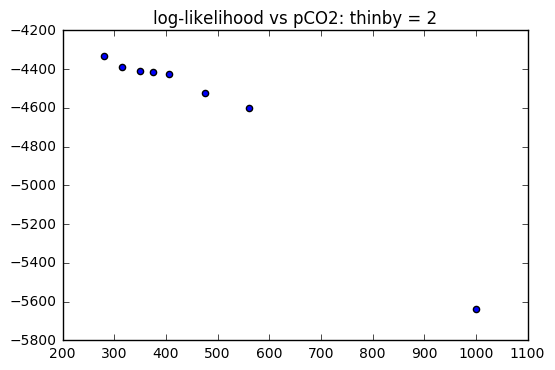

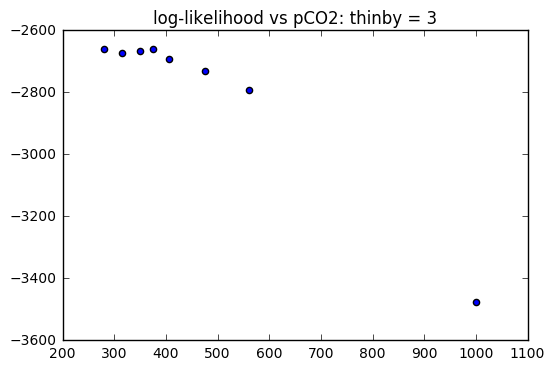

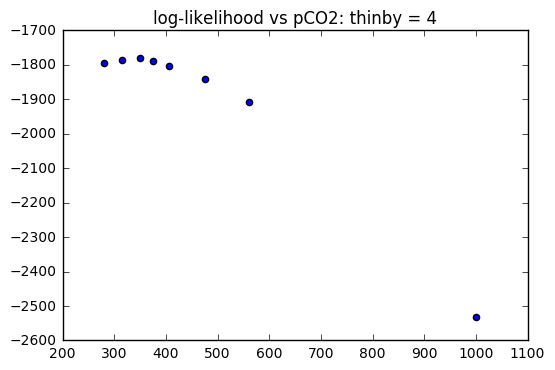

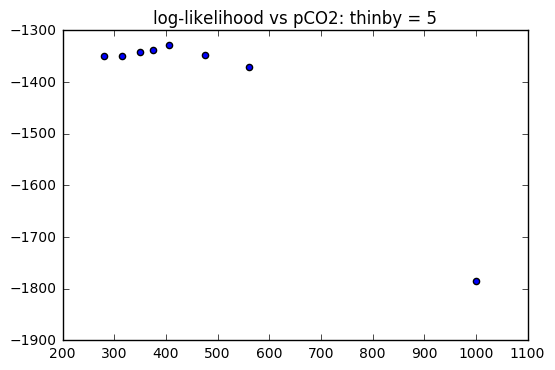

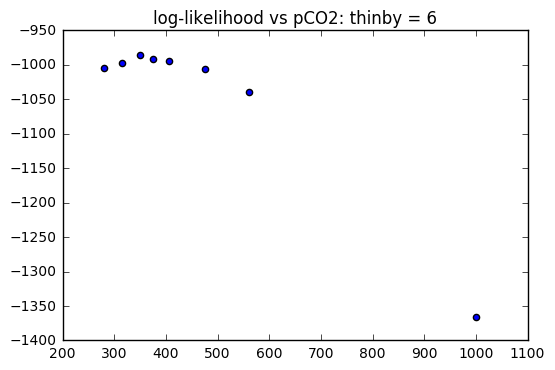

In [22]:


CO2 = np.zeros(8)
for ii in range(8):
    CO2[ii] = int(dict[gcm_runs_label[ii]].split(' ppm')[0])



for ii in (range(6)):
    ords= orderings[str(ii+1)]
    likes = loglikes[str(ii+1)]


    plt.figure()
    plt.scatter(CO2, likes)
    plt.title('log-likelihood vs pCO2: thinby = '+ str(ii+1))

What's happening? My best guess is that on the finer grid, the short scale correlations determine what we view as a good fit. Whereas on a coarser grid, thsoe short scale correlations are unimportant. Andrew's code presumably uses a fairly coarse mesh, and thus the similarity between the results above for the thinned grid and his. 

To test this, can we rerun Andrew's code so that it uses a finer mesh?